# Imports

Importing necessary modules and libraries, fetching and splitting the dataset, defining classes.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
from tqdm.auto import tqdm
from statistics import mean
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

In [3]:
from matplotlib.pyplot import figure

In [4]:
from transformers import BertTokenizer
import torch
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv("/content/drive/MyDrive/beer_df_large.csv", sep="\t")

In [9]:
df.sample(5)

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate
1065,Winterhammer,Schilling Beer Co.,Bocks,"New Hampshire, United States",Bock,6.9%,4.02,Orangey light brown cloudy body with two finge...,3.83
39497,Double Two Hearted Ale,Bell's Brewery - Eccentric Café & General Store,India Pale Ales,"Michigan, United States",Imperial IPA,11%,4.14,Phenomenal lacing-- very impressive hiding of ...,4.31
18652,Brime Red Lager,Ægir Bryggeri,Dark Lagers,Norway,American Amber / Red Lager,4.7%,3.71,On tap at the Cardinal in Stavanger. Served in...,3.83
116192,Apple Brandy Barrel Noir,Prairie Artisan Ales,Stouts,"Oklahoma, United States",American Imperial Stout,12%,4.48,I have never really been a fan of the apple br...,4.58
88879,Zwickel,Urban Chestnut Brewing Company - Midtown Brewe...,Pale Lagers,"Missouri, United States",Kellerbier / Zwickelbier,5.2%,3.85,"A go-to staple for me, this Bavarian lager has...",4.01


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [11]:
df['Flat'] = df.apply(lambda x: '{}. {}'.format(x['Group'], x['Style']), axis=1)

In [12]:
df_train, df_test = train_test_split(df, train_size=0.9, random_state=42, stratify=df['Flat'])
df_train, df_val = train_test_split(df_train, train_size=0.88889, random_state=42, stratify=df_train['Flat'])
print(len(df_train), len(df_test), len(df_val))

139746 17469 17469


In [13]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Define class labels
    classes = sorted(list(set(y_true)))
    
    # Create heatmap
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Evaluating the flat approach

The BERT classifier's targets are beer styles, i.e. specific types of beer. There is only one model that is trained on the entire dataset.

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Flat']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [15]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 116)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [16]:
model_path = '/content/drive/MyDrive/nn_4th_year/project/models/beert_flat.pt'
model = BertClassifier()
model = torch.load(model_path)
model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [17]:
labels = {}
for i, name in enumerate(df['Flat'].value_counts().index.tolist()):
  labels[name] = i

In [18]:
labels

{'Pale Lagers. American Adjunct Lager': 0,
 'Dark Lagers. Märzen': 1,
 'Pale Lagers. German Pilsner': 2,
 'Pale Lagers. European Pale Lager': 3,
 'Pale Lagers. American Lager': 4,
 'Pale Lagers. Helles': 5,
 'Stouts. Russian Imperial Stout': 6,
 'Stouts. American Imperial Stout': 7,
 'Pale Lagers. Bohemian / Czech Pilsner': 8,
 'Stouts. Sweet / Milk Stout': 9,
 'India Pale Ales. Imperial IPA': 10,
 'Strong Ales. Tripel': 11,
 'Porters. American Porter': 12,
 'Stouts. American Stout': 13,
 'India Pale Ales. American IPA': 14,
 'Pale Ales. English Pale Ale': 15,
 'Specialty Beers. Fruit and Field Beer': 16,
 'Stouts. Oatmeal Stout': 17,
 'Wheat Beers. Hefeweizen': 18,
 'Strong Ales. Belgian Pale Strong Ale': 19,
 'Specialty Beers. Pumpkin Beer': 20,
 'Strong Ales. Belgian Dark Strong Ale': 21,
 'Brown Ales. American Brown Ale': 22,
 'Pale Ales. American Blonde Ale': 23,
 'India Pale Ales. New England IPA': 24,
 'Wheat Beers. Witbier': 25,
 'Pale Ales. Saison': 26,
 'Pale Ales. American P

In [19]:
def evaluate(model, test_data):
    y_preds = []
    y_trues = []
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              y_preds.append(output.argmax(dim=1))
              y_trues.append(test_label)
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_preds, y_trues

In [20]:
y_preds, y_trues = evaluate(model, df_test)

100%|██████████| 8735/8735 [10:17<00:00, 14.14it/s]

Test Accuracy:  0.441


In [21]:
# Convert the predicted and true labels to numpy arrays
y_preds_ = torch.cat(y_preds).cpu().numpy()
y_trues_ = torch.cat(y_trues).cpu().numpy()

# Print the classification report
print(classification_report(y_trues_, y_preds_))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.35      0.54      0.43       302
           1       0.53      0.62      0.57       301
           2       0.45      0.47      0.46       293
           3       0.34      0.46      0.39       281
           4       0.22      0.21      0.22       280
           5       0.35      0.51      0.42       280
           6       0.39      0.38      0.39       279
           7       0.29      0.50      0.37       272
           8       0.47      0.35      0.40       272
           9       0.47      0.43      0.45       267
          10       0.46      0.50      0.48       265
          11       0.54      0.52      0.53       263
          12       0.30      0.47      0.37       260
          13       0.27      0.47      0.34       259
          14       0.46      0.58      0.51       258
          15       0.37      0.44      0.40       257
          16       0.43      0.49      0.46       254
          17       0.63    

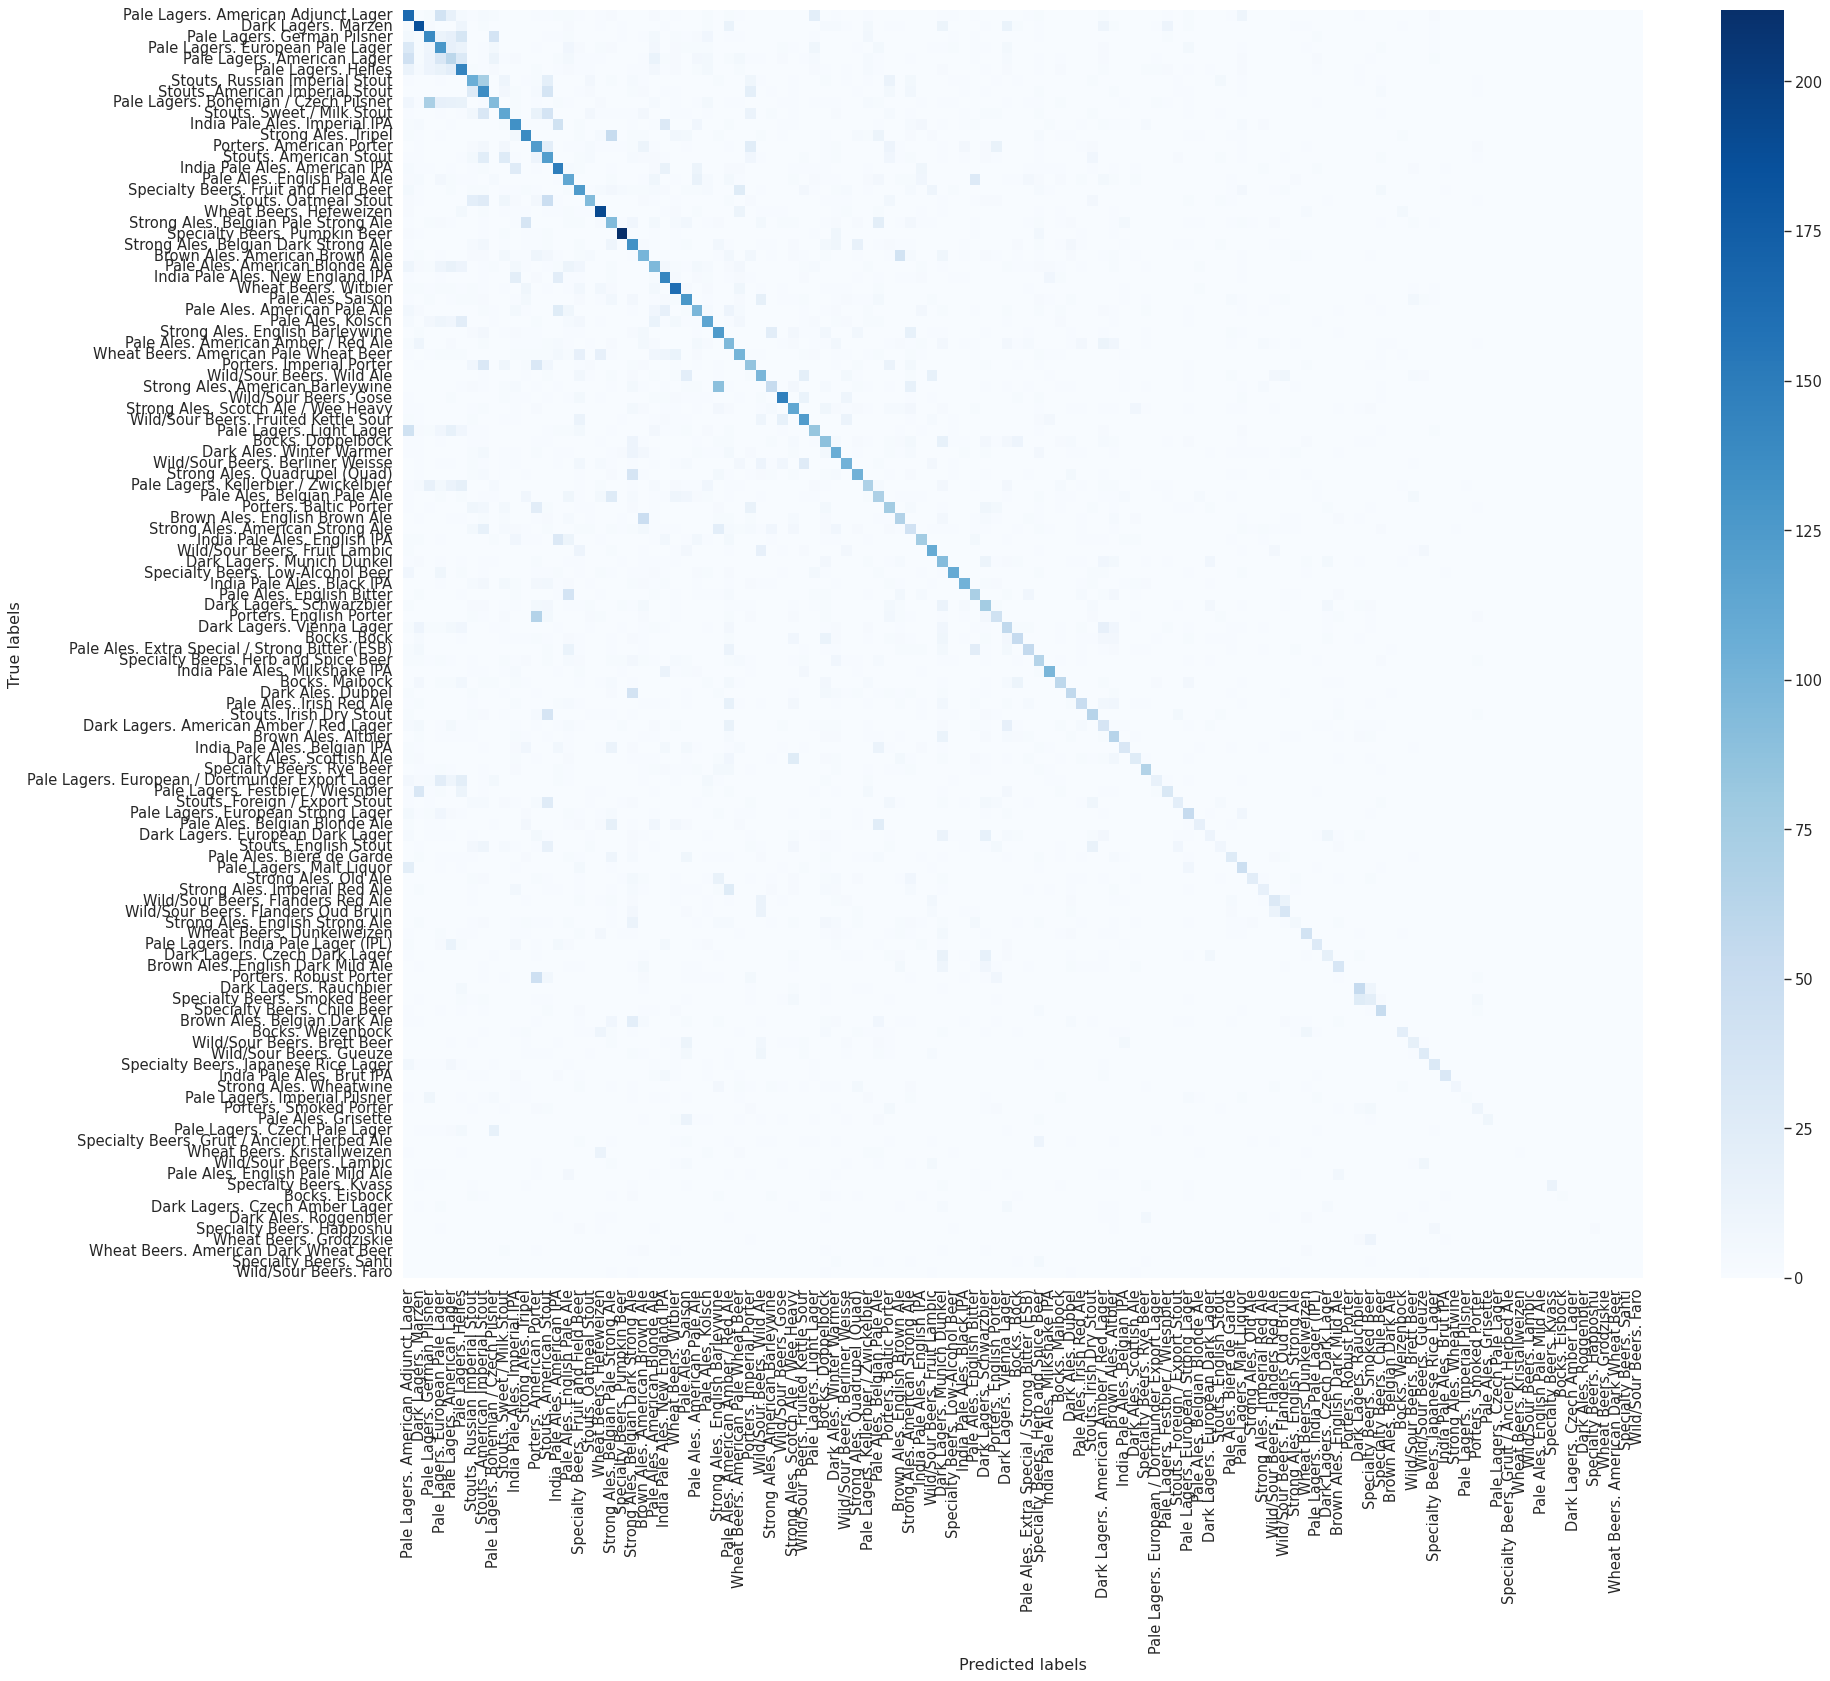

In [22]:
# Plot the confusion matrix
figure(figsize=(25, 21), dpi=80)

plot_confusion_matrix(y_trues_, y_preds_, labels)

Labels on cells are removed because the matrix is too large.

# Hierarchical approach

Two BERT classifiers are trained: the first classifier predicts a group the beer belongs in (e.g. 'Stouts'). The second classifier takes in the text + the predicted group and predicts a specific type of beer (e.g. 'Dark stout').

In [23]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Group']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [24]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 13)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [25]:
labels = {}
for i, name in enumerate(df['Group'].value_counts().index.tolist()):
  labels[name] = i

In [26]:
labels

{'Pale Lagers': 0,
 'Pale Ales': 1,
 'Strong Ales': 2,
 'Stouts': 3,
 'India Pale Ales': 4,
 'Wild/Sour Beers': 5,
 'Specialty Beers': 6,
 'Dark Lagers': 7,
 'Porters': 8,
 'Wheat Beers': 9,
 'Brown Ales': 10,
 'Bocks': 11,
 'Dark Ales': 12}

In [27]:
model_path = '/content/drive/MyDrive/nn_4th_year/project/models/hierarchical/class_1_dropout02_strat.pt'
model = BertClassifier()
model = torch.load(model_path)
model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [28]:
def evaluate(model, test_data):
    y_preds = []
    y_trues = []
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              y_preds.append(output.argmax(dim=1))
              y_trues.append(test_label)
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_preds, y_trues

In [29]:
y_preds, y_trues = evaluate(model, df_test)

Test Accuracy:  0.768


In [30]:
y_preds_ = torch.cat(y_preds).cpu().numpy()
y_trues_ = torch.cat(y_trues).cpu().numpy()

In [31]:
preds_labels = []
for i in y_preds_:
  for k,v in labels.items():
    if v == i:
      preds_labels.append(k)

In [32]:
trues_labels = []
for i in y_trues_:
  for k,v in labels.items():
    if v == i:
      trues_labels.append(k)

Second model

In [33]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 116)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [34]:
model_path2 = '/content/drive/MyDrive/nn_4th_year/project/models/hierarchical/beert_model_strat_hier.pt'
model2 = BertClassifier()
model2 = torch.load(model_path2)
model2.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [35]:
labels2 = {}
for i, name in enumerate(df_test['Style'].value_counts().index.tolist()):
  labels2[name] = i

In [36]:
df_test['Pred_group'] = preds_labels

In [37]:
df_test['Hier'] = df_test.apply(lambda x: 'Group: {}. Review: {}'.format(x['Pred_group'], x['Review']), axis=1)

In [38]:
df_test.sample(1)

,Name,Company,Group,Region,Style,ABV,Avg,Review,Rate,Flat,Pred_group,Hier
94081,Porter,Southern Tier Brewing Company,Porters,"New York, United States",American Porter,5.5%,3.68,They got the color right. It pours dark but wi...,2.19,Porters. American Porter,Dark Lagers,Group: Dark Lagers. Review: They got the color...


In [39]:
class Dataset2(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels2[label] for label in df['Style']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Hier']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [40]:
def evaluate2(model, test_data):
    y_preds = []
    y_trues = []
    test = Dataset2(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              y_preds.append(output.argmax(dim=1))
              y_trues.append(test_label)
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return y_preds, y_trues

In [41]:
y_preds, y_trues = evaluate2(model2, df_test)

100%|██████████| 8735/8735 [10:17<00:00, 14.13it/s]


Test Accuracy:  0.483


In [42]:
# Convert the predicted and true labels to numpy arrays
y_preds_ = torch.cat(y_preds).cpu().numpy()
y_trues_ = torch.cat(y_trues).cpu().numpy()

# Print the classification report
print(classification_report(y_trues_, y_preds_))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.34      0.59      0.43       302
           1       0.61      0.69      0.65       301
           2       0.42      0.61      0.50       293
           3       0.46      0.54      0.50       281
           4       0.33      0.29      0.31       280
           5       0.51      0.51      0.51       280
           6       0.43      0.47      0.45       279
           7       0.33      0.57      0.42       272
           8       0.37      0.50      0.43       272
           9       0.53      0.50      0.51       267
          10       0.57      0.43      0.49       265
          11       0.69      0.60      0.64       263
          12       0.43      0.45      0.44       260
          13       0.34      0.34      0.34       259
          14       0.42      0.59      0.50       258
          15       0.39      0.49      0.44       257
          16       0.52      0.61      0.56       254
          17       0.44    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


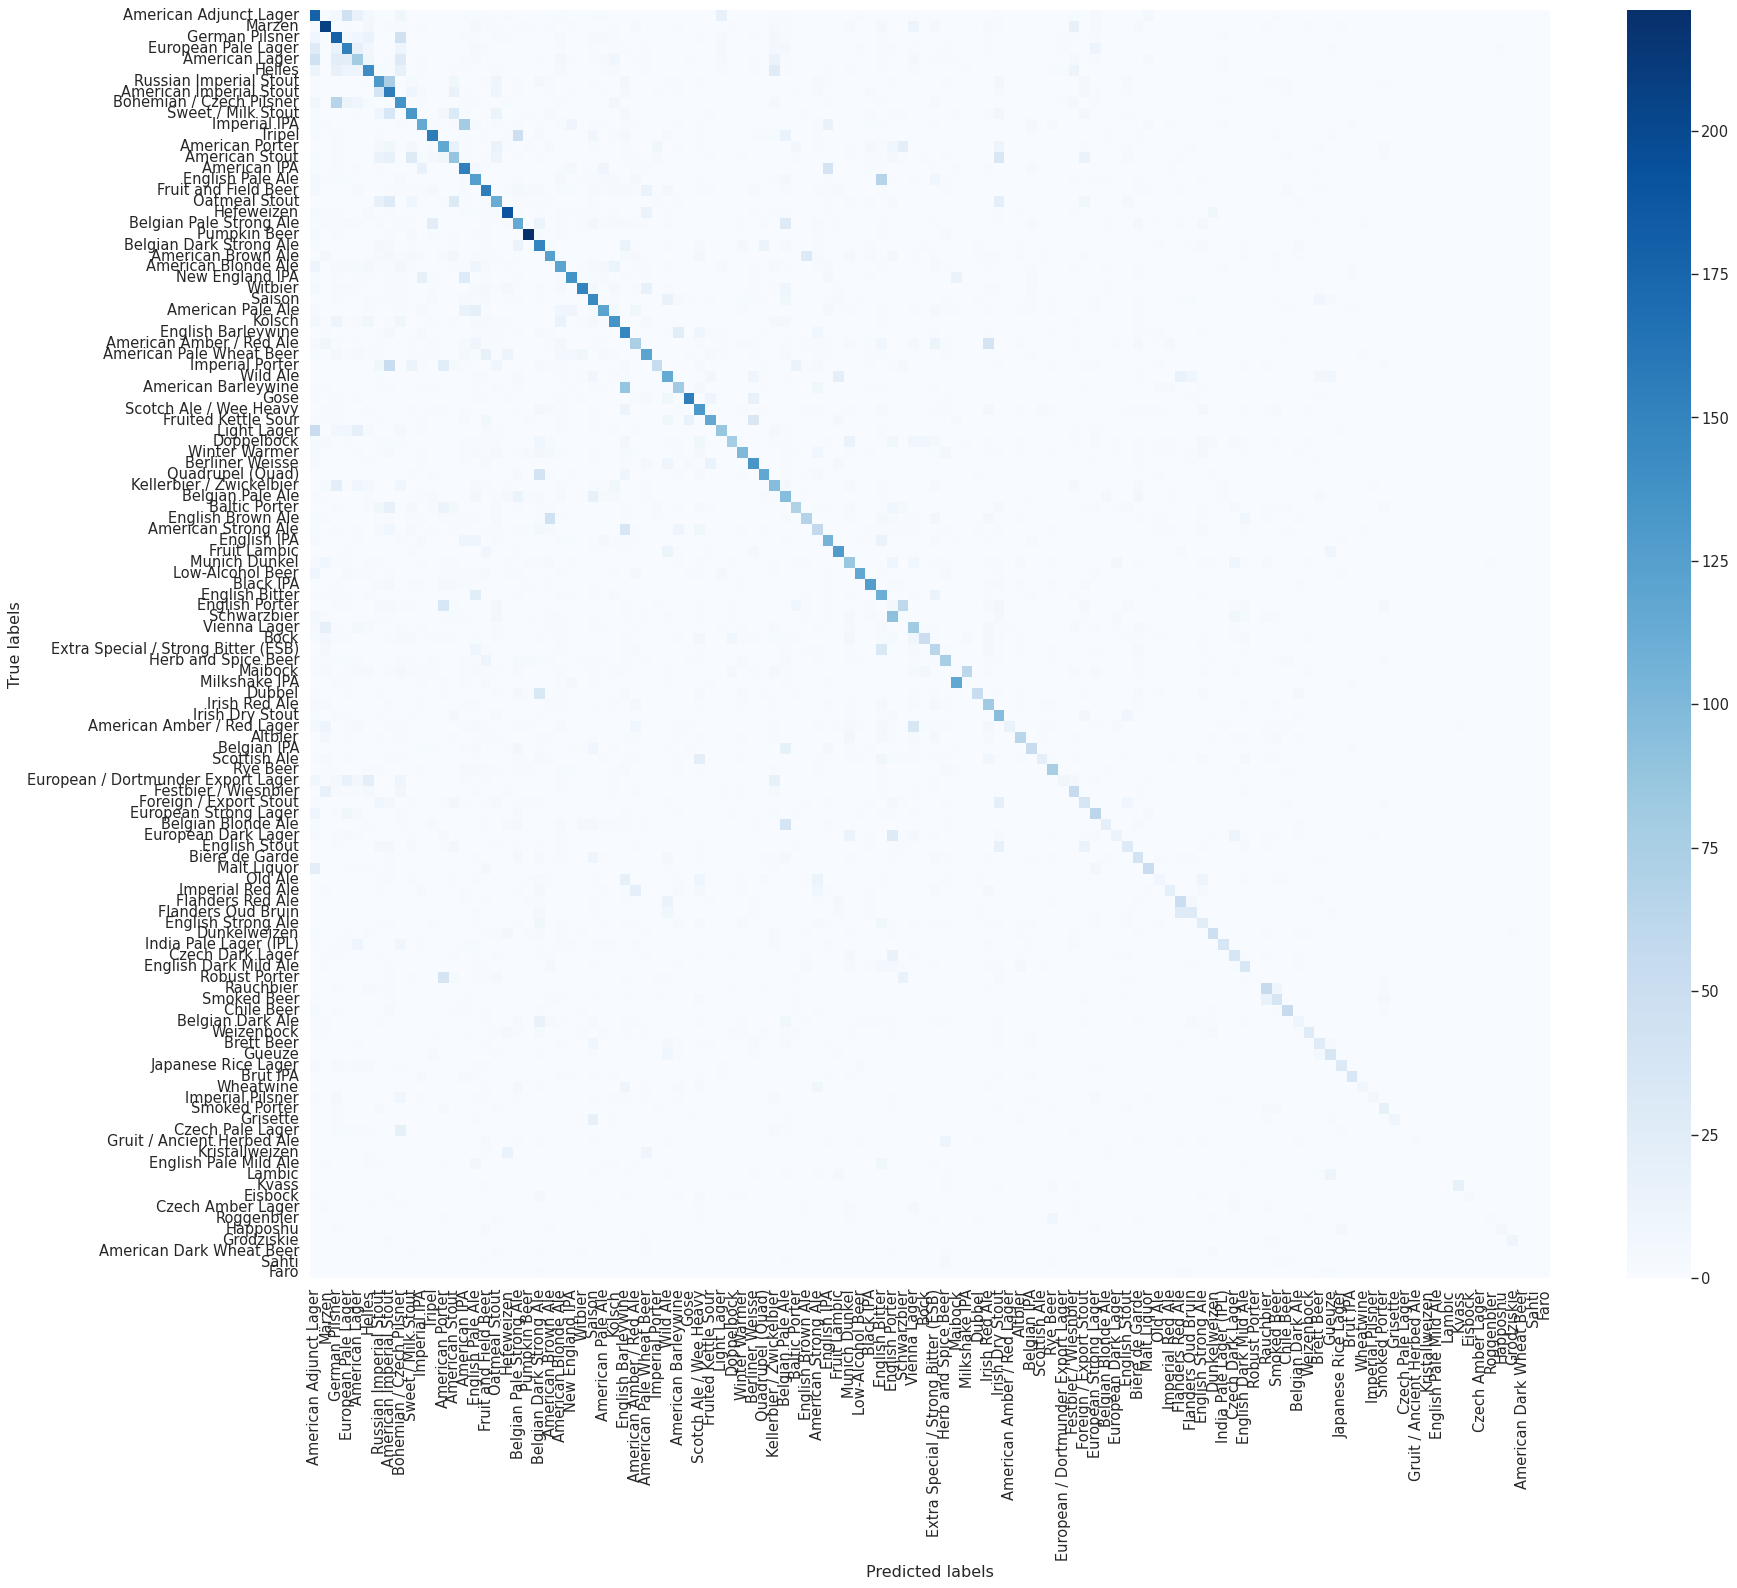

In [43]:
# Plot the confusion matrix
figure(figsize=(25, 21), dpi=80)

plot_confusion_matrix(y_trues_, y_preds_, labels2)